In [239]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
import scipy.stats as stats

import arviz as az

import stan

import jax.numpy as jnp
from jax.experimental.ode import odeint
from jax import jacobian

# Generate synthetic data

The Lotka-Volterra model is given by the equations:
$$\begin{split}
\frac{du_1}{dt} &= \theta_1 u_1 - \theta_2 u_1 u_2, \\
\frac{du_2}{dt} &= \theta_4 u_1 u_2 - \theta_3 u_2,
\end{split}$$
where $u_1$ and $u_20$ are populations of prey and preditor, respectively, and $\theta_1, \theta_2, \theta_3, \theta_4$ are model parameters. All the quantities are positive.

Define the Lotka-Volterra model:

In [3]:
def lotka_volterra(t, u, theta):
    theta1, theta2, theta3, theta4 = theta
    u1, u2 = u
    return [
        theta1 * u1 - theta2 * u1 * u2,
        theta4 * u1 * u2 - theta3 * u2,
    ]

Solve the coupled ODEs:

In [202]:
t_n = 2500  # number of time data points
t_span = [0, 25]  # the time span over which to integrate the system
theta = [0.67, 1.33, 1., 1.]  # parameters of the model
d = len(theta)  # dimension of the parameter space
u_init = [1., 1.]  # initial values

In [5]:
def solve_lotka_volterra(theta):
    sol = solve_ivp(lotka_volterra, t_span, u_init, args=(theta,), dense_output=True)
    t = np.linspace(t_span[0], t_span[1], t_n)
    return t, sol.sol(t).T

In [6]:
t, u = solve_lotka_volterra(theta)

Add Gaussian noise:

In [7]:
rng = np.random.default_rng(12345)

In [8]:
means = [0, 0]
C = np.diag([0.2 ** 2, 0.2 ** 2])

In [9]:
eps = stats.multivariate_normal.rvs(mean=means, cov=C, size=len(u), random_state=rng)
y = u + eps

Plot the resulting values:

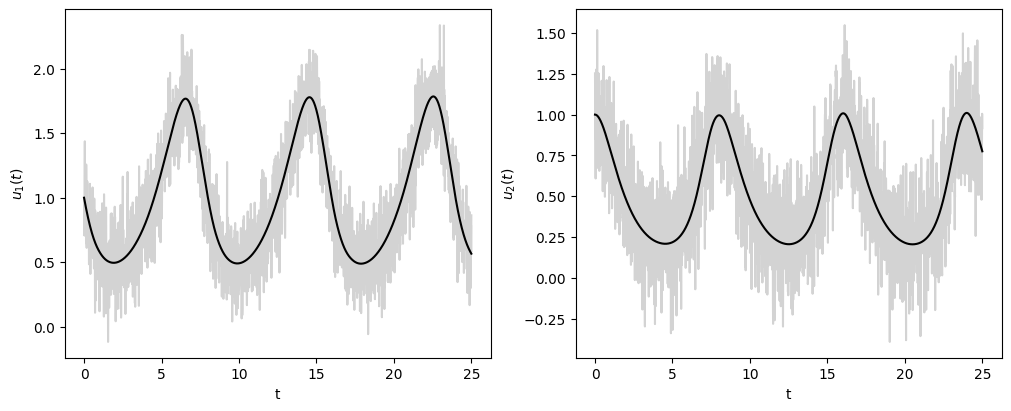

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
for i in range(2):
    axs[i].plot(t, y[:, i], color='lightgray');
    axs[i].plot(t, u[:, i], color='black');
    axs[i].set_xlabel('t');
    axs[i].set_ylabel(f'$u_{i + 1}(t)$');

# Sample using a handwritten random-walk Metropolis-Hastings algorithm

Implement random-walk Metropolis-Hastings algorithm by hand:

In [10]:
def sample_chain(theta_sampler, theta_init, n_samples):
    """Sample a single chain of given length using the starting the values provided"""
    # set the starting values
    theta = np.array(theta_init, copy=True)

    # create an array for the trace
    trace = np.empty((n_samples + 1, d))

    # store the initial values
    trace[0, :] = theta

    # sample variables
    for i in range(n_samples):
        # sample new theta
        theta = theta_sampler(theta)

        # record the value in the trace
        trace[i + 1, :] = theta

    return trace

In [11]:
def to_arviz(chains, var_names):
    """Convert output to arviz format"""
    assert len(chains) > 0
    return az.from_dict({
        var_name: np.stack([chain[:, i] for chain in chains]) for i, var_name in enumerate(var_names)
    })

In [12]:
def metropolis_random_walk_step(log_target_density, proposal_sampler):
    """Perform a Metropolis-Hastings random walk step"""
    def sampler(theta):
        # propose a new value
        theta_proposed = proposal_sampler(theta)

        # decide whether to accept the new value
        log_acceptance_probability = np.minimum(
            0, 
            log_target_density(theta_proposed) - log_target_density(theta)
        )
        u = rng.random()
        if u == 0 or np.log(u) < log_acceptance_probability:
            return theta_proposed
        else:
            return theta

    return sampler

In [13]:
def log_target_density(theta):
    _, u = solve_lotka_volterra(np.exp(theta))
    log_likelihood = np.sum(stats.multivariate_normal.logpdf(y - u, mean=means, cov=C))
    log_prior = np.sum(stats.norm.logpdf(theta))
    return log_likelihood + log_prior

In [14]:
def rw_proposal_sampler(step_size):
    G = step_size * np.identity(d)
    def sampler(theta):
        xi = stats.norm.rvs(size=d, random_state=rng)
        return theta + G @ xi
    return sampler

In [15]:
n_samples = 10_000

In [16]:
# TODO consider selecting step size following Gelman, Roberts, Gilks (1996) Efficient Metropolis Jumping Rules.
step_size = 0.01

In [16]:
theta_init = np.array([0.55, 1, 0.8, 0.8])

In [18]:
%%time
theta_sampler = metropolis_random_walk_step(log_target_density, rw_proposal_sampler(step_size))
rw_sample = sample_chain(theta_sampler, np.log(theta_init), n_samples)

CPU times: user 2min 13s, sys: 136 ms, total: 2min 13s
Wall time: 2min 14s


Reproduce the first column in Figure S17 from the Supplementary Material:

In [19]:
def plot_trace(samples):
    fig, axs = plt.subplots(1, samples.shape[1], figsize=(15, 3), constrained_layout=True)
    for i in range(d):
        axs[i].plot(samples[:, i]);
        axs[i].set_xscale('log');
        axs[i].set_xlabel('n');
        axs[i].set_ylabel(f'Parameter {i + 1}');

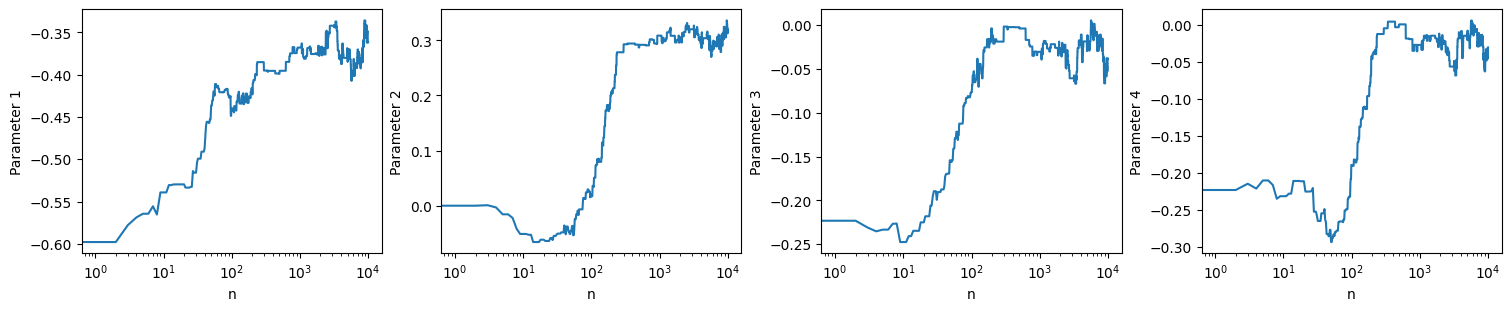

In [20]:
plot_trace(rw_sample)

# Sample using Stan

The implementation follows https://mc-stan.org/docs/stan-users-guide/odes.html#estimating-system-parameters-and-initial-state.

In [11]:
import nest_asyncio
nest_asyncio.apply()

In [12]:
stan_model_spec = """
functions {
  vector lotka_volterra(real t, vector u, vector theta) {
    vector[2] dudt;
    dudt[1] = exp(theta[1]) * u[1] - exp(theta[2]) * u[1] * u[2];
    dudt[2] = exp(theta[4]) * u[1] * u[2] - exp(theta[3]) * u[2];
    return dudt;
  }
}
data {
  int<lower=1> T;
  array[T] vector[2] y;
  real t0;
  array[T] real ts;
  vector[2] u0;
  vector<lower=0>[2] sigma;
}
parameters {
  vector[4] theta;
}
model {
  array[T] vector[2] u = ode_rk45(lotka_volterra, u0, t0, ts, theta);
  theta ~ std_normal();
  for (t in 1:T) {
    y[t] ~ normal(u[t], sigma);
  }
}
"""

In [13]:
data = {
    'T': t_n - 1,  # the first time is 0, for which the initial values are fixed
    'y': y[1:, :],
    't0': t_span[0],
    'ts': t[1:],
    'u0': u_init,
    'sigma': np.diag(C),  # TODO pass a matrix and use a multivariate normal in the Stan model
}

In [23]:
n_samples = 1_000

In [24]:
%%time
inference_model = stan.build(stan_model_spec, data=data, random_seed=12345)
stan_sample = inference_model.sample(num_chains=1, num_samples=n_samples, init=[{'theta': np.log(theta_init)}])

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_c56rs2u_/model_rmdlkygl.stan', line 22, column 25: The
    variable lotka_volterra may not have been assigned a value before its
    use.
Sampling:   0%
Sampling:   0% (1/2000)
Sampling:   5% (100/2000)
Sampling:  10% (200/2000)
Sampling:  15% (300/2000)
Sampling:  20% (400/2000)
Sampling:  25% (500/2000)
Sampling:  30% (600/2000)
Sampling:  35% (700/2000)
Sampling:  40% (800/2000)
Sampling:  45% (900/2000)
Sampling:  50% (1000/2000)
Sampling:  50% (1001/2000)
Sampling:  55% (1100/2000)
Sampling:  60% (1200/2000)
Sampling:  65% (1300/2000)
Sampling:  70% (1400/2000)
Sampling:  75% (1500/2000)
Sampling:  80% (1600/2000)
Sampling:  85% (1700/2000)
Sampling:  90% (1800/2000)
Sampling:  95% (1900/2000)
Sampling: 100% (2000/2000)
Sampling: 100% (2000/2000), done.
Messages received during sampling:
  Gradient evaluation took 0.003089 seconds
  1000 transitions using 10 leapfrog steps per transition would take 30.8

CPU times: user 4.9 s, sys: 602 ms, total: 5.5 s
Wall time: 2min 48s


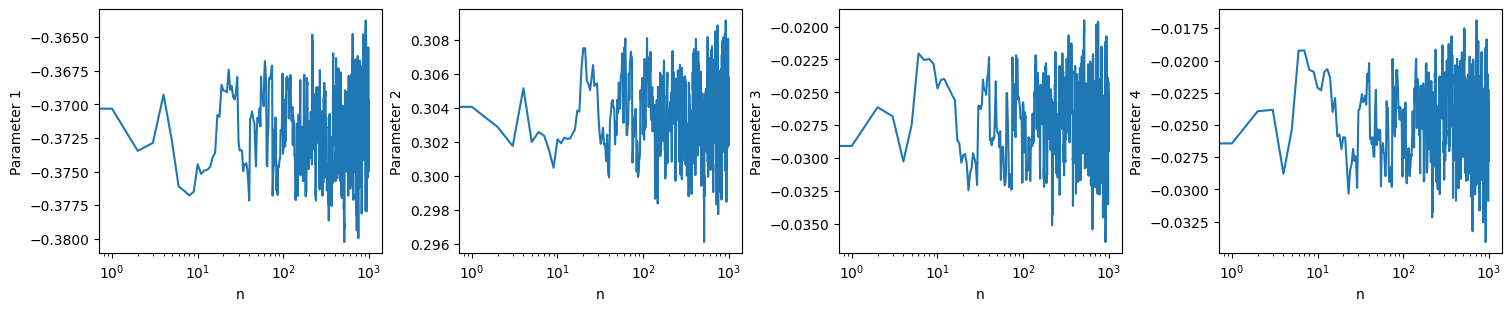

In [25]:
plot_trace(stan_sample['theta'].T)

# Sensitivity analysis

## Forward sensitivity equations

Given a system of ODEs of the form:
$$\frac{du_r}{dt} = F_q(t, u_1, \dots, u_q; x),\qquad r=1,\dots,q,$$
the sensitivities can be found by solving forward sensitivity equations:
$$\frac{d}{dt}\left(\frac{\partial u_r}{\partial x_s}\right) = \frac{dF_r}{dx_s} + \sum_{l=1}^q \frac{\partial F_r}{\partial u_l} \frac{\partial u_l}{\partial x_s}$$
with initial conditions
$$\frac{\partial u_r}{\partial x_s}(0) = 0.$$

For the Lotka-Volterra model, the forward sensitivity equations are:
$$\begin{split}
\frac{d}{dt}\left(\frac{\partial u_1}{\partial \theta_1}\right) &= u_1 + (\theta_1 - \theta_2 u_2) \frac{\partial u_1}{\partial \theta_1} - \theta_2 u_1 \frac{\partial u_2}{\partial \theta_1}, \\
\frac{d}{dt}\left(\frac{\partial u_1}{\partial \theta_2}\right) &= - u_1 u_2 + (\theta_1 - \theta_2 u_2) \frac{\partial u_1}{\partial \theta_2} - \theta_2 u_1 \frac{\partial u_2}{\partial \theta_2}, \\
\frac{d}{dt}\left(\frac{\partial u_1}{\partial \theta_3}\right) &= (\theta_1 - \theta_2 u_2) \frac{\partial u_1}{\partial \theta_3} - \theta_2 u_1 \frac{\partial u_2}{\partial \theta_3}, \\
\frac{d}{dt}\left(\frac{\partial u_1}{\partial \theta_4}\right) &= (\theta_1 - \theta_2 u_2) \frac{\partial u_1}{\partial \theta_4} - \theta_2 u_1 \frac{\partial u_2}{\partial \theta_4}, \\
\frac{d}{dt}\left(\frac{\partial u_2}{\partial \theta_1}\right) &= \theta_4 u_2 \frac{\partial u_1}{\partial \theta_1} + (\theta_4 u_1 - \theta_3) \frac{\partial u_2}{\partial \theta_1}, \\
\frac{d}{dt}\left(\frac{\partial u_2}{\partial \theta_2}\right) &= \theta_4 u_2 \frac{\partial u_1}{\partial \theta_2} + (\theta_4 u_1 - \theta_3) \frac{\partial u_2}{\partial \theta_2}, \\
\frac{d}{dt}\left(\frac{\partial u_2}{\partial \theta_3}\right) &= -u_2 + \theta_4 u_2 \frac{\partial u_1}{\partial \theta_3} + (\theta_4 u_1 - \theta_3) \frac{\partial u_2}{\partial \theta_3}, \\
\frac{d}{dt}\left(\frac{\partial u_2}{\partial \theta_4}\right) &= u_1 u_2 + \theta_4 u_2 \frac{\partial u_1}{\partial \theta_4} + (\theta_4 u_1 - \theta_3) \frac{\partial u_2}{\partial \theta_4}. \\
\end{split}$$

Denoting $w_1 = \frac{\partial u_1}{\partial \theta_1}$, $w_2 = \frac{\partial u_1}{\partial \theta_2}$, $w_3 = \frac{\partial u_1}{\partial \theta_3}$, $w_4 = \frac{\partial u_1}{\partial \theta_4}$ and $w_5 = \frac{\partial u_2}{\partial \theta_1}$, $w_6 = \frac{\partial u_2}{\partial \theta_2}$, $w_7 = \frac{\partial u_2}{\partial \theta_3}$, $w_8 = \frac{\partial u_2}{\partial \theta_4}$, we have the following additional equations:
$$\begin{split}
\frac{dw_1}{dt} &= u_1 + (\theta_1 - \theta_2 u_2) w_1 - \theta_2 u_1 w_5, \\
\frac{dw_2}{dt} &= - u_1 u_2 + (\theta_1 - \theta_2 u_2) w_2 - \theta_2 u_1 w_6, \\
\frac{dw_3}{dt} &= (\theta_1 - \theta_2 u_2) w_3 - \theta_2 u_1 w_7, \\
\frac{dw_4}{dt} &= (\theta_1 - \theta_2 u_2) w_4 - \theta_2 u_1 w_8, \\
\frac{dw_5}{dt} &= \theta_4 u_2 w_1 + (\theta_4 u_1 - \theta_3) w_5, \\
\frac{dw_6}{dt} &= \theta_4 u_2 w_2 + (\theta_4 u_1 - \theta_3) w_6, \\
\frac{dw_7}{dt} &= -u_2 + \theta_4 u_2 w_3 + (\theta_4 u_1 - \theta_3) w_7, \\
\frac{dw_8}{dt} &= u_1 u_2 + \theta_4 u_2 w_4 + (\theta_4 u_1 - \theta_3) w_8. \\
\end{split}$$

In [245]:
def lotka_volterra_sensitivity(t, uw, theta):
    theta1, theta2, theta3, theta4 = theta
    u1, u2, w1, w2, w3, w4, w5, w6, w7, w8 = uw
    return [
        # model equations
        theta1 * u1 - theta2 * u1 * u2,
        theta4 * u1 * u2 - theta3 * u2,
        # sensitivities
        u1 + (theta1 - theta2 * u2) * w1 - theta2 * u1 * w5,
        -u1 * u2 + (theta1 - theta2 * u2) * w2 - theta2 * u1 * w6,
        (theta1 - theta2 * u2) * w3 - theta2 * u1 * w7,
        (theta1 - theta2 * u2) * w4 - theta2 * u1 * w8,
        theta4 * u2 * w1 + (theta4 * u1 - theta3) * w5,
        theta4 * u2 * w2 + (theta4 * u1 - theta3) * w6,
        -u2 + theta4 * u2 * w3 + (theta4 * u1 - theta3) * w7,
        u1 * u2 + theta4 * u2 * w4 + (theta4 * u1 - theta3) * w8,
    ]

In [246]:
uw_init = np.concatenate([np.array(u_init), np.zeros(d * 2)])

In [247]:
%%time
sol = solve_ivp(lotka_volterra_sensitivity, t_span, uw_init, args=(theta,), dense_output=True)
sensitivity_forward = sol.sol(t).T

CPU times: user 34.4 ms, sys: 143 μs, total: 34.6 ms
Wall time: 32.9 ms


Plot the sensitivities for the true model:

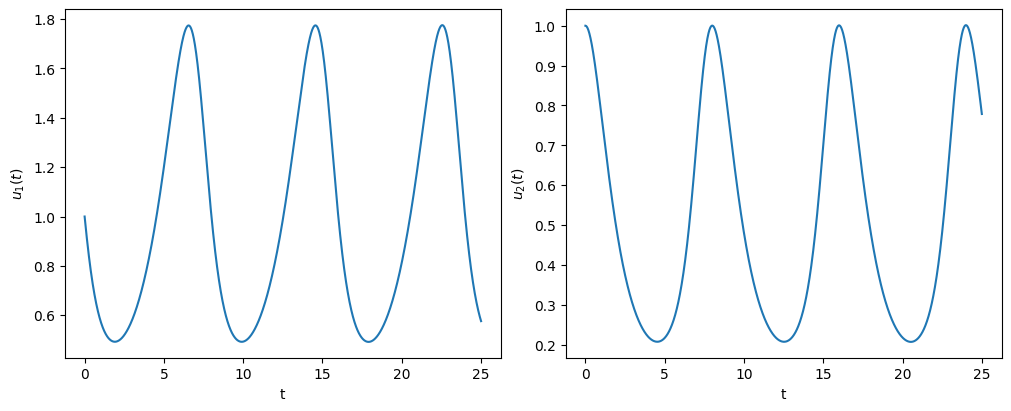

In [248]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
for i in range(2):
    axs[i].plot(t, sensitivity_forward[:, i]);
    axs[i].set_xlabel('t');
    axs[i].set_ylabel(f'$u_{i + 1}(t)$');

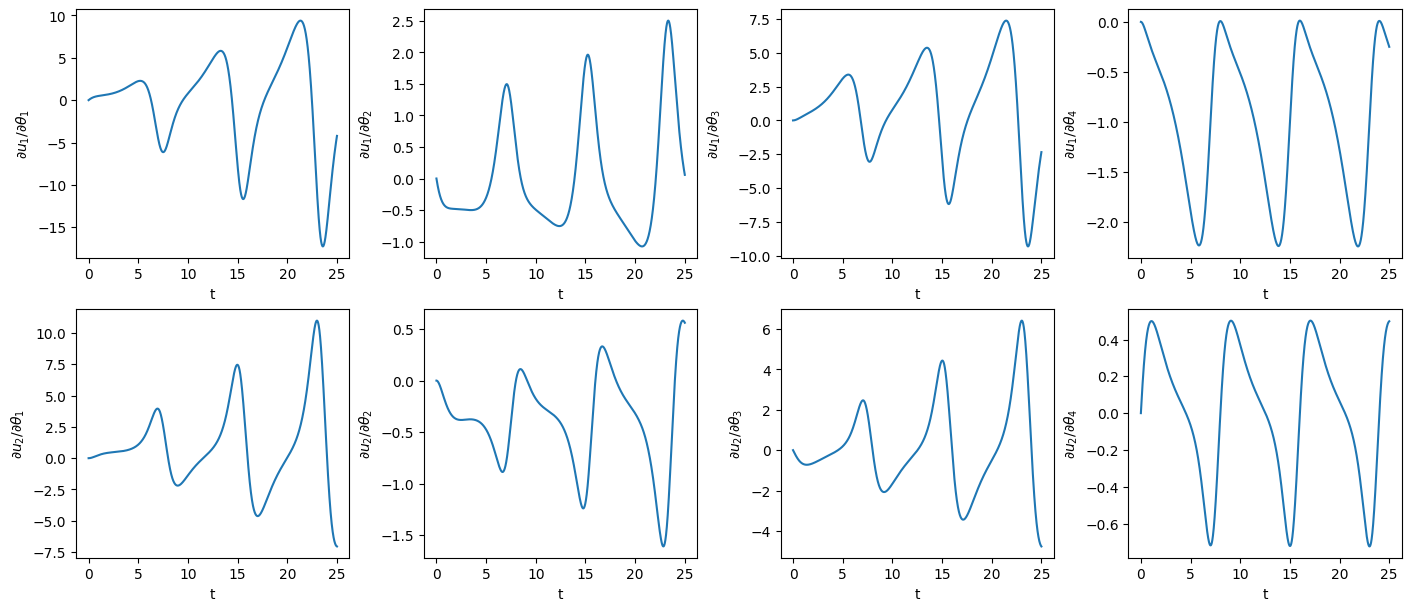

In [249]:
fig, axs = plt.subplots(2, 4, figsize=(14, 6), constrained_layout=True)
for i in range(2):
    for j in range(d):
        axs[i][j].plot(t, sensitivity_forward[:, 2 + i * d + j]);
        axs[i][j].set_xlabel('t');
        axs[i][j].set_ylabel(f'$\\partial u_{{{i + 1}}} / \\partial \\theta_{{{j + 1}}}$');

## Numerical Jacobian calculation

Redefine the function as ``jax.experimental.ode.odeint`` passes the state variable in the first argument and time in the second argument:

In [250]:
def lotka_volterra2(u, t, theta):
    return [
        theta[0] * u[0] - theta[1] * u[0] * u[1],
        theta[3] * u[0] * u[1] - theta[2] * u[1],
    ]

In [251]:
def solve_lotka_volterra2(theta):
    return odeint(lotka_volterra2, jnp.array(u_init), jnp.array(t), jnp.array(theta))

In [252]:
sol = solve_lotka_volterra2(theta)

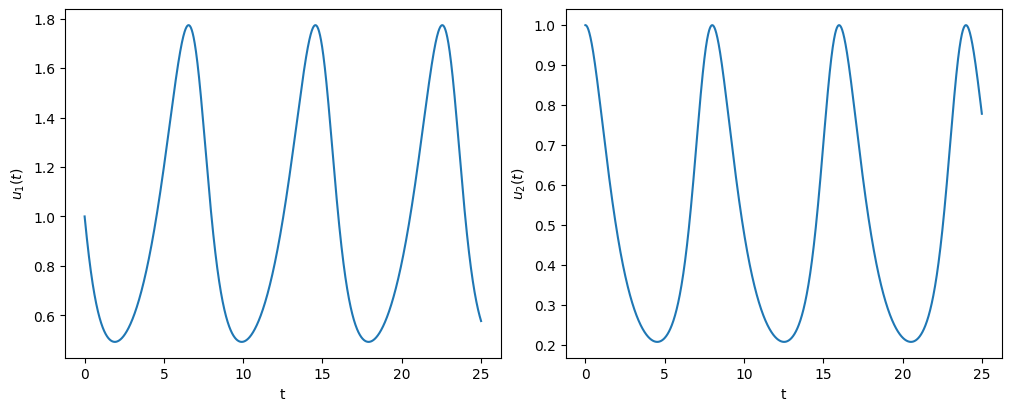

In [253]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
for i in range(2):
    axs[i].plot(t, sol[:, i]);
    axs[i].set_xlabel('t');
    axs[i].set_ylabel(f'$u_{i + 1}(t)$');

In [254]:
%%time
sensitivity_jax = jacobian(solve_lotka_volterra2)(theta)

CPU times: user 31.6 s, sys: 517 ms, total: 32.1 s
Wall time: 29.7 s


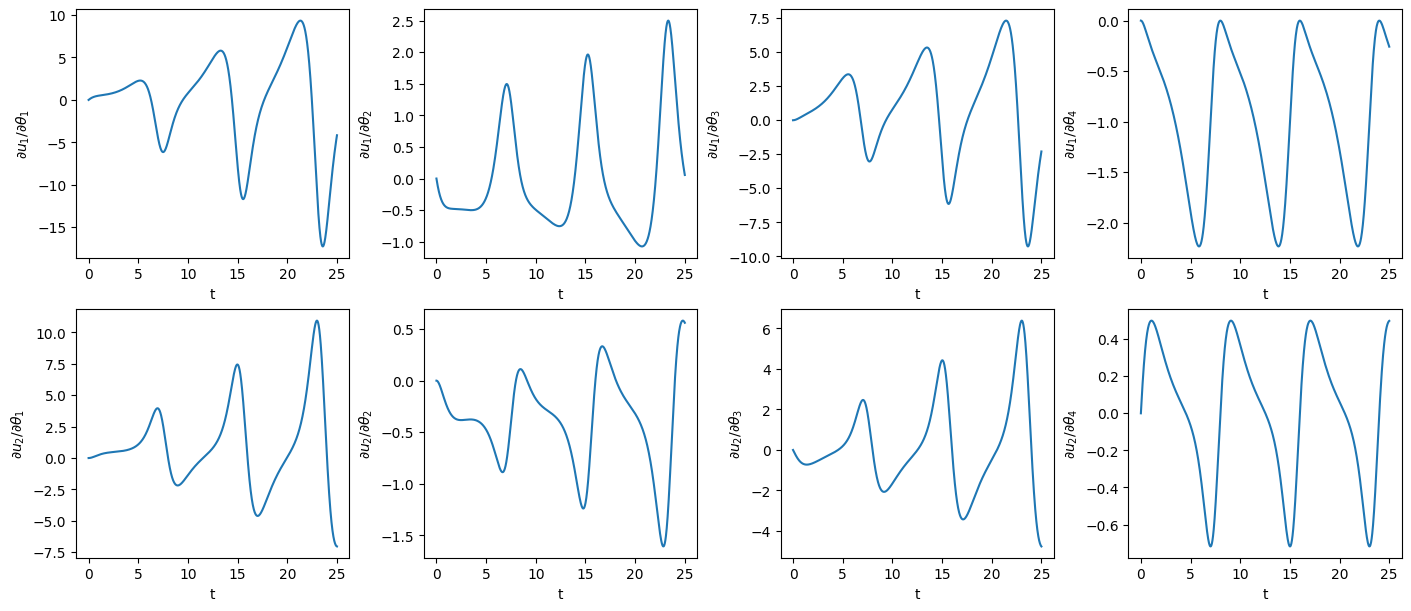

In [255]:
fig, axs = plt.subplots(2, 4, figsize=(14, 6), constrained_layout=True)
for i in range(2):
    for j in range(d):
        axs[i][j].plot(t, sensitivity_jax[j][:, i], label='JAX');
        axs[i][j].plot(t, sensitivity_forward[:, 2 + i * d + j], label='Forward equations');
        axs[i][j].set_xlabel('t');
        axs[i][j].set_ylabel(f'$\\partial u_{{{i + 1}}} / \\partial \\theta_{{{j + 1}}}$');